<a href="https://colab.research.google.com/github/Gooogr/Brain2Image/blob/master/sub_notebooks/PyTorch_DGAN_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Based on: <br>
https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html<br>
https://github.com/pytorch/tutorials/blob/master/beginner_source/dcgan_faces_tutorial.py<br>
https://github.com/nashory/gans-awesome-applications<br>
https://github.com/soumith/ganhacks

In [1]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt

import torch
import torch.nn as nn                        # torch layers
import torch.nn.parallel                     # parallel computation
import torchvision.datasets as dset          # dataset generator
import torchvision.transforms as transforms  # data transformers 
import torchvision.utils as vutils           # create image grid
import torch.optim as optim                  # optimizers


from torchsummary import summary             #create keras-like summary tables

In [2]:
! nvidia-smi

Thu Sep 17 20:44:01 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED);

In [4]:
#DATAROOT = 
#THREADS = 
BATCH_SIZE = 128
IMAGE_SIZE = 64
CHANNELS = 3 #number of color channels
NZ =  100 # length of latent vector
NGF = 64 # relates to the depth of feature maps carried through the generator
NDF = 64 # sets the depth of feature maps propagated through the discriminator
EPOCHS = 5
LR = 0.0002 #learning rate for training. As described in the DCGAN paper, this number should be 0.0002
BETA1 = 0.5 #beta1 hyperparameter for Adam optimizers. As described in paper, this number should be 0.5
NGPU = 1

In [5]:
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

### Prepare dataset

In [6]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
! ln -s "/content/drive/My Drive" "/content/mydrive"

Mounted at /content/drive


Download .zip archive

In [7]:
zip_path = '/content/mydrive/EEG2Image_research/Datasets/img_align_celeba.zip'
! mkdir /content/data
! unzip -qq $zip_path -d /content/data
print('Samples amount:')
!ls -l /content/data/img_align_celeba | wc -l

Samples amount:
202600


Create dataloader

In [8]:
dataset = dset.ImageFolder(root='/content/data',
                           transform=transforms.Compose([
                                transforms.Resize(IMAGE_SIZE),
                                transforms.CenterCrop(IMAGE_SIZE),
                                transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

In [9]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

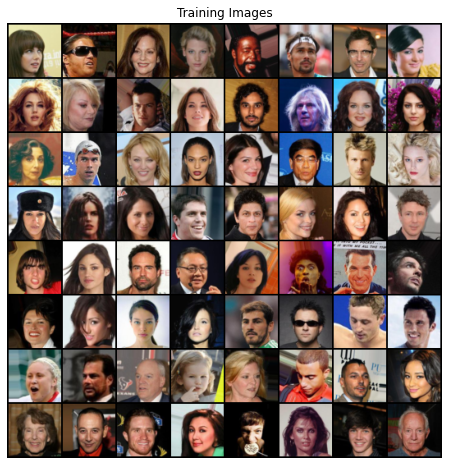

In [10]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

### Setting up model

Weight Initialization <br>

From the DCGAN paper, the authors specify that all model weights shall
be randomly initialized from a Normal distribution with mean=0,
stdev=0.02. The ``weights_init`` function takes an initialized model as
input and reinitializes all convolutional, convolutional-transpose, and
batch normalization layers to meet this criteria. This function is
applied to the models immediately after initialization.


In [11]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

Generator

![](https://raw.githubusercontent.com/Gooogr/Brain2Image/master/imgs/figures/face_gan_generator.png)

In [12]:
class Generator(nn.Module):

    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # Input is Z, going into convolution
            nn.ConvTranspose2d(in_channels=NZ, out_channels=(NGF * 8), kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(num_features=(NGF * 8)),
            nn.ReLU(inplace=True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(in_channels=(NGF * 8), out_channels=(NGF * 4), kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(NGF * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( NGF * 4, NGF * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(NGF * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( NGF * 2, NGF, 4, 2, 1, bias=False),
            nn.BatchNorm2d(NGF),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( NGF, CHANNELS, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )
    def forward(self, input):
        return self.main(input)

In [13]:
netG = Generator(NGPU).to(device)

In [14]:
#Handle multi-gpu
if device.type == 'cuda' and NGPU > 1:
    netG = nn.DataParallel(netG, list(range(NGPU)))



In [15]:
# Apply the weights_init function to randomly initialize all weights
# to mean=0, stdev=0.2.
netG = netG.apply(weights_init) #?


In [16]:
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [17]:
summary(netG, (100, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]         819,200
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]           3,072
             Tanh-14            [-1, 3,

Discriminator

In [18]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(CHANNELS, NDF, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(NDF, NDF * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(NDF * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(NDF * 2, NDF * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(NDF * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(NDF * 4, NDF * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(NDF * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(NDF * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [19]:
netD = Discriminator(NGPU).to(device)

In [20]:
#Handle multi-gpu
if device.type == 'cuda' and NGPU > 1:
    netD = nn.DataParallel(netD, list(range(NGPU)))

In [21]:
netD = netD.apply(weights_init)

In [22]:
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [23]:
summary(netD, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,072
         LeakyReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3          [-1, 128, 16, 16]         131,072
       BatchNorm2d-4          [-1, 128, 16, 16]             256
         LeakyReLU-5          [-1, 128, 16, 16]               0
            Conv2d-6            [-1, 256, 8, 8]         524,288
       BatchNorm2d-7            [-1, 256, 8, 8]             512
         LeakyReLU-8            [-1, 256, 8, 8]               0
            Conv2d-9            [-1, 512, 4, 4]       2,097,152
      BatchNorm2d-10            [-1, 512, 4, 4]           1,024
        LeakyReLU-11            [-1, 512, 4, 4]               0
           Conv2d-12              [-1, 1, 1, 1]           8,192
          Sigmoid-13              [-1, 1, 1, 1]               0
Total params: 2,765,568
Trainable param

Loss functions and optimizers

In [24]:
# Initialize binary cross entropy function
criterion = nn.BCELoss()

# Create batch of latent vector that we will use to 
# visualize the generator's progression
fixed_noise = torch.randn(64, NZ,  1, 1, device=device)

# Establish convertion for real and fake labels during the traning
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(params=netD.parameters(), lr=LR, betas=(BETA1, 0.999))  #params - parameters for optimization
optimizerG = optim.Adam(params=netG.parameters(), lr=LR, betas=(BETA1, 0.999))  

### Traning 

Training is split up into two main parts. First part
updates the Discriminator and the second part updates the Generator.<br>

**Train the Discriminator**<br>
The goal of training the discriminator is to maximize the
probability of correctly classifying a given input as real or fake.
Practically, we want to maximize  `log(D(x)) + log(1-D(G(z)))`<br>
We will calculate in two steps:
1. Construct a batch of real samples from the training set, forward
pass through `D`, calculate the loss `log(D(x))`, then calculate the gradients in a backward pass.
2. Construct a batch of fake samples with the current generator, forward pass this batch through `D`, calculate the loss `log(1-D(G(z)))`,
 and *accumulate* the gradients with a backward pass.

Now, with the gradients accumulated from both the all-real and all-fake batches, we call a step of the Discriminator’s optimizer.

**Train the Generator**<br>
As stated in the original paper, we want to train the Generator by
minimizing `log(1-D(G(z)))` in an effort to generate better fakes.
As mentioned, this was shown by Goodfellow to not provide sufficient
gradients, especially early in the learning process. As a fix, we
instead wish to maximize `log(D(G(z)))`.<br>
In the code we accomplish this by: 
1. Classifying the Generator output from Part 1 with the
Discriminator 
2. Computing G’s loss *using real labels as GT* 
3. Computing G’s gradients in a backward pass 
4. Finally updating G’s parameters with an optimizer step. 

It may seem counter-intuitive to use the real
 labels as GT labels for the loss function, but this allows us to use the
 `log(x)` part of the BCELoss (rather than the `log(1-x)`
 part) which is exactly what we want.




In [33]:
real_batch[0].size(0)

128

In [ ]:
# Lists for keeping up progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Training started!")
for epoch in range(EPOCHS):
    # For each batch in dataloader
    for i, data in enumerate(dataloader, start=0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        batch_size = real_cpu.size(0)
        label = torch.full((batch_size, ), real_label, dtype=torch.float, device=device)
        # Forward pass real batch trough D  
        output = netD(real_cpu).view(-1)
        # Calculate loss
        errD_real = criterion(output, label)
        # Calculate gradients in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(batch_size, NZ, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, EPOCHS, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == EPOCHS-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1




Training started!
[0/5][0/1583]	Loss_D: 0.8048	Loss_G: 6.5811	D(x): 0.9146	D(G(z)): 0.4441 / 0.0025
[0/5][50/1583]	Loss_D: 0.2078	Loss_G: 25.1644	D(x): 0.8972	D(G(z)): 0.0000 / 0.0000
[0/5][100/1583]	Loss_D: 0.7743	Loss_G: 13.0641	D(x): 0.9776	D(G(z)): 0.4664 / 0.0000
[0/5][150/1583]	Loss_D: 0.5109	Loss_G: 7.4463	D(x): 0.9504	D(G(z)): 0.2946 / 0.0016
[0/5][200/1583]	Loss_D: 0.2415	Loss_G: 5.1238	D(x): 0.9388	D(G(z)): 0.1437 / 0.0086
[0/5][250/1583]	Loss_D: 0.6088	Loss_G: 5.6784	D(x): 0.8928	D(G(z)): 0.3138 / 0.0079
[0/5][300/1583]	Loss_D: 0.5410	Loss_G: 4.4550	D(x): 0.9012	D(G(z)): 0.3031 / 0.0238
[0/5][350/1583]	Loss_D: 0.7771	Loss_G: 1.9186	D(x): 0.5968	D(G(z)): 0.0579 / 0.1992
[0/5][400/1583]	Loss_D: 0.7072	Loss_G: 3.7874	D(x): 0.6119	D(G(z)): 0.0244 / 0.0429
[0/5][450/1583]	Loss_D: 0.3852	Loss_G: 4.0166	D(x): 0.9025	D(G(z)): 0.2119 / 0.0323
[0/5][500/1583]	Loss_D: 0.4967	Loss_G: 3.4804	D(x): 0.7324	D(G(z)): 0.0764 / 0.0485
[0/5][550/1583]	Loss_D: 1.3911	Loss_G: 7.9218	D(x): 0.9675	